Initialize

In [ ]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import model_selection
from sklearn.ensemble import GradientBoostingRegressor
import keras_tuner
from scipy import stats
seed = 123

import warnings
warnings.filterwarnings("ignore")

Import data and concatenate

In [2]:
outs = pl.read_excel("Data/Outcomes/outcomes.xlsx")
preds = pl.read_csv("Data/Predictors/Sleep(1).csv")
for i in range(9):
    temp = pl.read_csv(f"Data/Predictors/Sleep({i + 2}).csv")
    preds = pl.concat([preds, temp], how = "vertical")
preds = preds.rename({"Sleep Score 4 Weeks": "Date", "Score": "Sleep Score"})

# Retain only useful columns
preds = preds.select(pl.nth(0,1,2,3,5, 6, 7))

# Convert date column to date format
preds = preds.with_columns(
    (pl.col("Date") + " 2024")
    .str.strptime(pl.Date, format="%b %e %Y")
    .alias("Date"))

Merge factors and outcome on date

In [3]:
# Note: the predictors are mnissing data for 9/24/24 due to crossing the dateline.
df = preds.join(outs, how = "inner", on = "Date")

Convert temperature changes to numeric

In [4]:
df = df.with_columns(
    pl.col("Skin Temp Change").str.strip_chars_end("°").cast(pl.Float64))

EDA

Mean active calories: 228.5300751879699
Standard deviation of active calories: 123.39002682365873


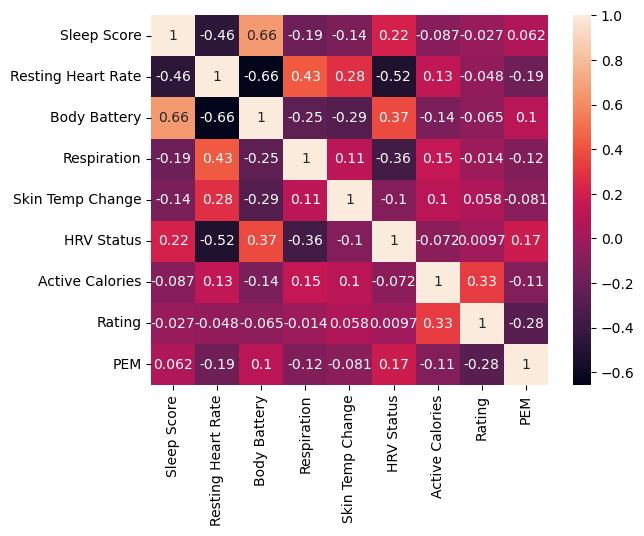

In [5]:
dfp = df.to_pandas()
matrix = dfp.iloc[:, 1:10].corr()
sns.heatmap(matrix, annot=True)

# Check average to get sense of meaningfully close predictions
print(f"Mean active calories: {np.mean(dfp.iloc[:, 7])}")
print(f"Standard deviation of active calories: {np.std(dfp.iloc[:, 7])}")

## Despite some collinearity, no variables appear duplicative.
## The low correlations between the outcomes and any other variable, including other outcomes,
    ## portend ill for the analysis' success.

Split data into training and test sets

In [6]:
# Split between train and test sets
## Prioritizing training due to small dataset
dfp_train, dfp_test = train_test_split(dfp.iloc[:, 1:], test_size=0.2, random_state=seed)
X_train = dfp_train.iloc[:, 0:6]
y_train = np.array(dfp_train.iloc[:, 6])
X_test = dfp_test.iloc[:, 0:6]
y_test = np.array(dfp_test.iloc[:, 6])

Create model in sklearn with tuning by keras using cross-validation.  
**Will simply use previous results unless they're deleted before running.**

In [ ]:
def build_model(hp):
  model = GradientBoostingRegressor(
    random_state = seed,
    learning_rate = hp.Float('LR', 1e-5, 1e-1, sampling='log'),
    n_estimators= 100,  # default = 100,
    subsample = hp.Float('subsample', 0.1, 1.0),
    min_samples_split = hp.Float('split', 0.01, 1.0),
    min_samples_leaf = hp.Int('leaf', 1, 10),
    min_weight_fraction_leaf = hp.Float('weight', 0.0, 0.5),
    max_depth = hp.Int('depth', 1, 100),
    max_features = hp.Float('features', 0.1, 1.0),
    max_leaf_nodes = hp.Int('nodes', 2, 200),
    )
  return model

tuner = keras_tuner.tuners.SklearnTuner(
    oracle=keras_tuner.oracles.BayesianOptimizationOracle(
        objective=keras_tuner.Objective('score', 'min'),
        max_trials=1000),
    hypermodel=build_model,
    scoring=metrics.make_scorer(metrics.mean_squared_error),
    cv=model_selection.KFold(n_splits=5, shuffle=True, random_state=seed),
    directory='.',
    project_name='cal_reg_gb')
    
tuner.search(X_train, y_train)  # 90 minutes!


Trial 1000 Complete [00h 00m 00s]
score: 14854.50702780573

Best score So Far: 14438.871916835225
Total elapsed time: 01h 22m 18s


In [10]:
tuner.results_summary(1)

Results summary
Results in .\cal_reg_gb
Showing 1 best trials
Objective(name="score", direction="min")

Trial 0156 summary
Hyperparameters:
LR: 0.050311714141855104
subsample: 1.0
split: 0.5001645512478805
leaf: 7
weight: 0.4208413651042762
depth: 54
features: 0.7609750259438585
nodes: 106
Score: 14438.871916835225


In [11]:
best_model = tuner.get_best_models(num_models=1)[0]
predictions = best_model.predict(X_test) # make predictions

Checking correlation of predictions to actual results, using test set 

Correlation between observations and predictions: 0.19024074836931534
MAE: 94.78973894456016
Standard deviation of MAE: 86.85508010859822


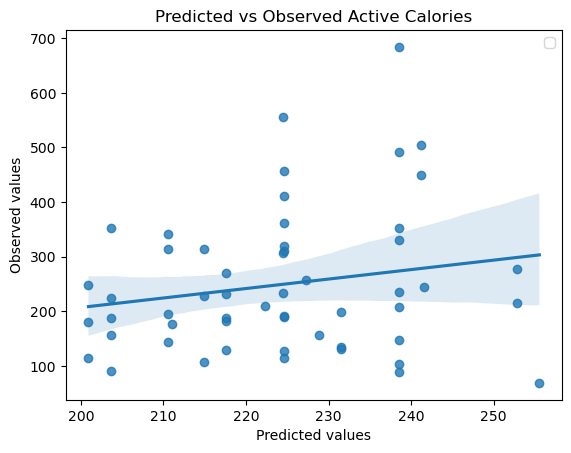

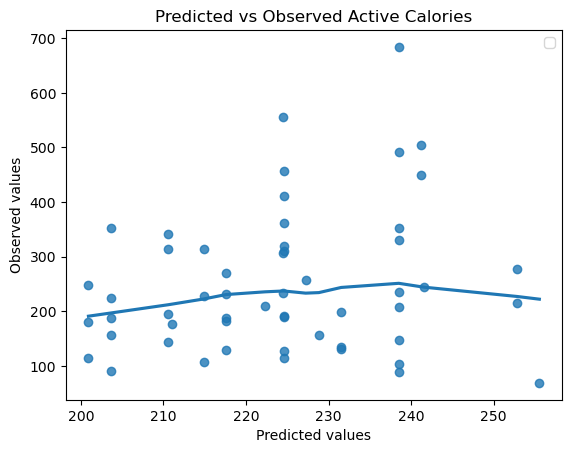

In [ ]:
# Plotting lowess and linear regression lines, with 95% confidence interval for latter

print(f'Correlation between observations and predictions: {np.corrcoef(y_test, predictions.flatten())[1][0]}')

# Calculating the standard deviation of the errors:
mae = np.mean(np.absolute(np.subtract(y_test, predictions.flatten())))
print(f'MAE: {mae}')
print(f'Standard deviation of MAE: {np.std(np.absolute(np.subtract(y_test, predictions.flatten())))}')

sns.regplot(y = y_test, x = predictions)
plt.title('Predicted vs Observed Active Calories')
plt.xlabel('Predicted values')
plt.ylabel('Observed values')
plt.legend()
plt.show()

sns.regplot(y = y_test, x = predictions, lowess = True)
plt.title('Predicted vs Observed Active Calories')
plt.xlabel('Predicted values')
plt.ylabel('Observed values')
plt.legend()
plt.show()


Predictions vs observations using full data 

Correlation between observations and predictions: 0.20142894207307202
MAE: 89.49831785280294
Standard deviation of MAE: 82.24749279928355


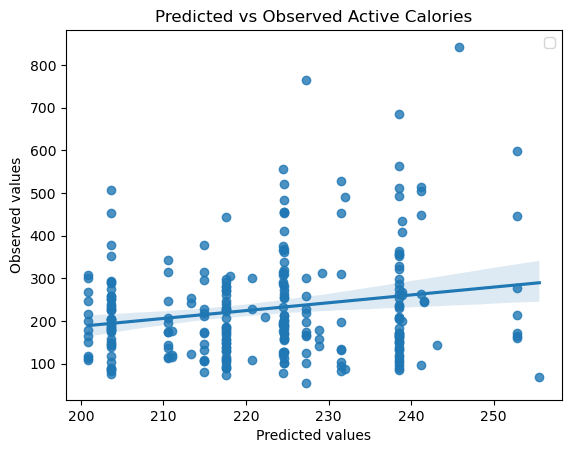

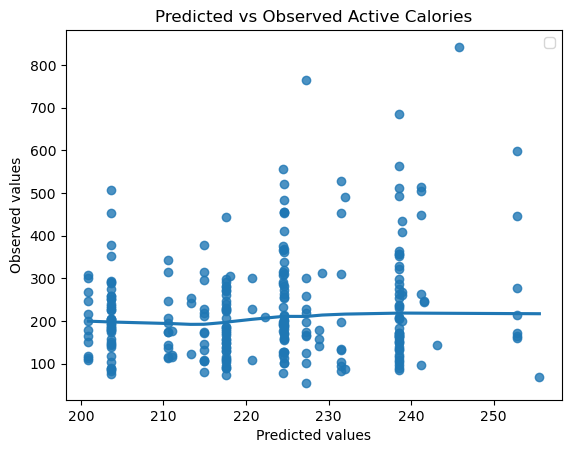

In [ ]:
predictions_full = best_model.predict(dfp.iloc[:, 1:7])
print(f'Correlation between observations and predictions: {np.corrcoef(dfp.iloc[:, 7], predictions_full.flatten())[1][0]}')

# Calculating the standard deviation of the errors:
mae = np.mean(np.absolute(np.subtract(dfp.iloc[:, 7], predictions_full.flatten())))
print(f'MAE: {mae}')
print(f'Standard deviation of MAE: {np.std(np.absolute(np.subtract(dfp.iloc[:, 7], predictions_full.flatten())))}')

sns.regplot(y = dfp.iloc[:, 7], x = predictions_full)
plt.title('Predicted vs Observed Active Calories')
plt.xlabel('Predicted values')
plt.ylabel('Observed values')
plt.legend()
plt.show()

sns.regplot(y = dfp.iloc[:, 7], x = predictions_full, lowess = True)
plt.title('Predicted vs Observed Active Calories')
plt.xlabel('Predicted values')
plt.ylabel('Observed values')
plt.legend()
plt.show()

**Discussion:** The model makes predictions along a range of about 60, whereas observations have a range of about 800, or at least 600 without outliers. The plots show what the weak correlation measures: any predicted value might actually correspond to almost any observed value. In short, this is a useless model.

The MAE and its standard deviation are lower than for for the neural network. However, the correlation and the plotted pattern are weaker.